In [1]:
import numpy as np
from libpysal.weights import lat2W, Kernel
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc
import libpysal as ps  # Ensure PySAL is installed
from libpysal.weights import DistanceBand, lat2W, Kernel
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
from scipy.stats import pearsonr

from numpy.linalg import inv

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Define autocorrelation function. 
def draw_map(N, lamb, W, random_state=None):
    """
    N    = number of areal units
    lamb = spatial autocorrelation parameter
    W    = spatial weights matrix
    random_state = optional seed for reproducibility
    """
    if random_state is not None:
        np.random.seed(random_state)

    W.transform = "r"
    e = np.random.random((N, 1))
    u = inv(np.eye(N) - lamb * W.full()[0])
    u = np.dot(u, e)
    u = (u - u.mean()) / np.std(u)
    return u

# Function to create tract polygons over the area
def create_tracts(xmin, xmax, ymin, ymax, x_step, y_step):
    polys = []
    ids = []
    id_counter = 0
    for x0 in np.arange(xmin, xmax, x_step):
        for y0 in np.arange(ymin, ymax, y_step):
            x1 = x0 + x_step
            y1 = y0 + y_step
            poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
            polys.append(poly)
            ids.append(id_counter)
            id_counter += 1
    gdf = gpd.GeoDataFrame({'tract_id': ids, 'geometry': polys})
    return gdf

# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

orig_tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step) # this is important as its used in 16x16 visualiation

### Simulate Spatially Varying Beta Surface

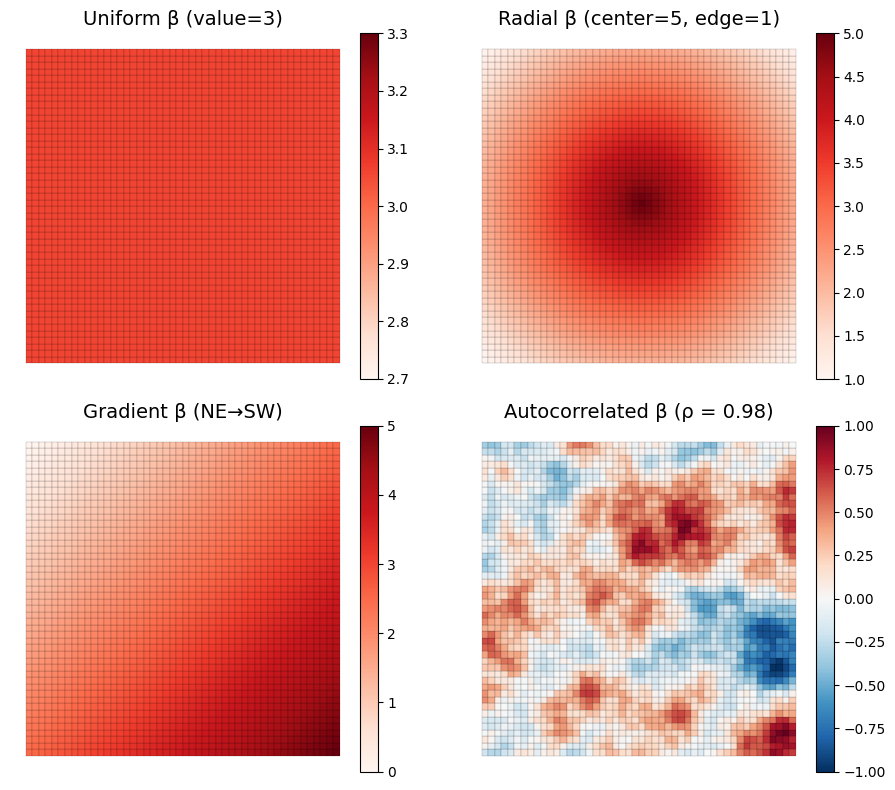

In [3]:
def uniform(Nlat, value=3):
 
    return np.full((Nlat**2, 1), value)

uniform_beta = uniform(48)

def radial(Nlat, center_value=5, edge_value=1):
    grid = np.zeros((Nlat, Nlat))
    cx, cy = Nlat / 2, Nlat / 2
    max_dist = np.sqrt((cx)**2 + (cy)**2)

    for i in range(Nlat):
        for j in range(Nlat):
            dist = np.sqrt((i - cx)**2 + (j - cy)**2)
            weight = 1 - (dist / max_dist)  # normalized to [0, 1]
            grid[i, j] = edge_value + (center_value - edge_value) * weight

    return grid.flatten().reshape(-1, 1)

radial_beta = radial(48)

def gradient(Nlat, min_val=0, max_val=5):

    # Create row (Y) and column (X) indices
    rows, cols = np.meshgrid(np.arange(Nlat), np.arange(Nlat), indexing='ij')
    
    # Normalize and invert diagonal direction
    diag_gradient = (rows + (Nlat - 1 - cols)) / (2 * (Nlat - 1))  # NE to SW
    
    # Rescale to desired range
    beta_vals = min_val + (max_val - min_val) * diag_gradient
    return beta_vals.reshape(-1, 1)

gradient_beta = gradient(48)

## Generate beta
Nlat = 48
N = Nlat**2

W = lat2W(Nlat, Nlat, rook=True)

np.random.seed(2025)
beta_surface = draw_map(N, 0.98, W)

beta_surface_scaled = 2 * (beta_surface - beta_surface.min()) / (beta_surface.max() - beta_surface.min()) - 1

tracts_gdf48['uniform_beta'] = uniform_beta
tracts_gdf48['radial_beta'] = radial_beta
tracts_gdf48['gradient_beta'] = gradient_beta
tracts_gdf48['autocorr_beta'] = beta_surface_scaled

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
cmap = plt.cm.RdBu_r
cmap2 = plt.cm.Reds

# Uniform Beta
tracts_gdf48.plot(column="uniform_beta", cmap=cmap2, linewidth=0.1, edgecolor='k',
                  ax=axes[0, 0], vmin=0, vmax=5)
axes[0, 0].set_title("Uniform β (value=3)", fontsize=14)
axes[0, 0].axis('off')
sm1 = cm.ScalarMappable(cmap=cmap2, norm=mcolors.Normalize(
    vmin=tracts_gdf48["uniform_beta"].min(), vmax=tracts_gdf48["uniform_beta"].max()))
sm1._A = []
fig.colorbar(sm1, ax=axes[0, 0], orientation="vertical", fraction=0.046, pad=0.01)

# Radial Beta
tracts_gdf48.plot(column="radial_beta", cmap=cmap2, linewidth=0.1, edgecolor='k',
                  ax=axes[0, 1])
axes[0, 1].set_title("Radial β (center=5, edge=1)", fontsize=14)
axes[0, 1].axis('off')
sm2 = cm.ScalarMappable(cmap=cmap2, norm=mcolors.Normalize(
    vmin=tracts_gdf48["radial_beta"].min(), vmax=tracts_gdf48["radial_beta"].max()))
sm2._A = []
fig.colorbar(sm2, ax=axes[0, 1], orientation="vertical", fraction=0.046, pad=0.01)

# Gradient Beta
tracts_gdf48.plot(column="gradient_beta", cmap=cmap2, linewidth=0.1, edgecolor='k',
                  ax=axes[1, 0])
axes[1, 0].set_title("Gradient β (NE→SW)", fontsize=14)
axes[1, 0].axis('off')
sm3 = cm.ScalarMappable(cmap=cmap2, norm=mcolors.Normalize(
    vmin=tracts_gdf48["gradient_beta"].min(), vmax=tracts_gdf48["gradient_beta"].max()))
sm3._A = []
fig.colorbar(sm3, ax=axes[1, 0], orientation="vertical", fraction=0.046, pad=0.01)

# Spatially Autocorrelated Beta
tracts_gdf48.plot(column="autocorr_beta", cmap=cmap, linewidth=0.1, edgecolor='k',
                  ax=axes[1, 1])
axes[1, 1].set_title("Autocorrelated β (ρ = 0.98)", fontsize=14)
axes[1, 1].axis('off')
sm4 = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(
    vmin=tracts_gdf48["autocorr_beta"].min(), vmax=tracts_gdf48["autocorr_beta"].max()))
sm4._A = []
fig.colorbar(sm4, ax=axes[1, 1], orientation="vertical", fraction=0.046, pad=0.01)

plt.tight_layout()
plt.show()

## Create 3 variables that will be on the same support as the target variable

In [4]:
N = 48**2
W = lat2W(48, 48, rook=True)

autocorr_level = [0.60, 0.65, 0.80] # alter the correlation levels

S1 = draw_map(N, autocorr_level[0], W, random_state=101)
S2 = draw_map(N, autocorr_level[1], W, random_state=202)
S3 = draw_map(N, autocorr_level[2], W, random_state=303)

tracts_gdf48["S1"] = S1.flatten()
tracts_gdf48["S2"] = S2.flatten()
tracts_gdf48["S3"] = S3.flatten()


In [5]:
same_sup = tracts_gdf48.copy()

### visualize the variables 

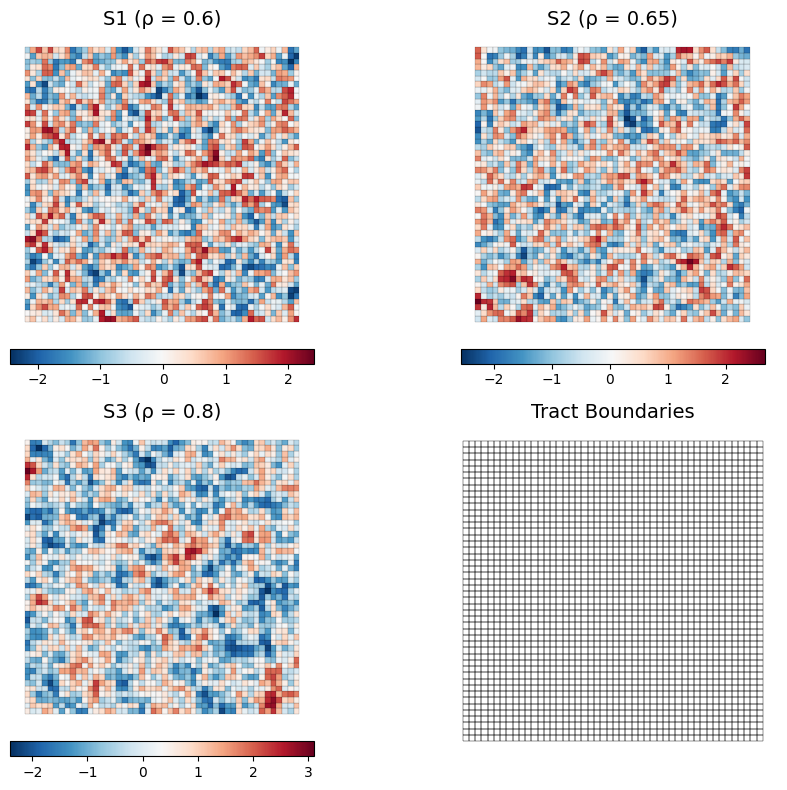

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
cmap = plt.cm.RdBu_r

# Plot S1
s1_plot = tracts_gdf48.plot(column="S1", cmap=cmap, linewidth=0.1, edgecolor='k',
                            ax=axes[0, 0])
axes[0, 0].set_title(f"S1 (ρ = {autocorr_level[0]})", fontsize=14)
axes[0, 0].axis('off')
sm1 = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(
    vmin=tracts_gdf48["S1"].min(), vmax=tracts_gdf48["S1"].max()))
sm1._A = []
fig.colorbar(sm1, ax=axes[0, 0], orientation="horizontal", fraction=0.046, pad=0.04)

# Plot S2
s2_plot = tracts_gdf48.plot(column="S2", cmap=cmap, linewidth=0.1, edgecolor='k',
                            ax=axes[0, 1])
axes[0, 1].set_title(f"S2 (ρ = {autocorr_level[1]})", fontsize=14)
axes[0, 1].axis('off')
sm2 = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(
    vmin=tracts_gdf48["S2"].min(), vmax=tracts_gdf48["S2"].max()))
sm2._A = []
fig.colorbar(sm2, ax=axes[0, 1], orientation="horizontal", fraction=0.046, pad=0.04)

# Plot S3
s3_plot = tracts_gdf48.plot(column="S3", cmap=cmap, linewidth=0.1, edgecolor='k',
                            ax=axes[1, 0])
axes[1, 0].set_title(f"S3 (ρ = {autocorr_level[2]})", fontsize=14)
axes[1, 0].axis('off')
sm3 = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(
    vmin=tracts_gdf48["S3"].min(), vmax=tracts_gdf48["S3"].max()))
sm3._A = []
fig.colorbar(sm3, ax=axes[1, 0], orientation="horizontal", fraction=0.046, pad=0.04)

# Plot tract boundaries
tracts_gdf48.boundary.plot(ax=axes[1, 1], linewidth=0.3, color="black")
axes[1, 1].set_title("Tract Boundaries", fontsize=14)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# S2.shape

## Simulate Y

In [8]:
# rng = np.random.default_rng(seed=27)
# error_term = rng.normal(0, 0.50, len(S2))

# y_orig = (uniform_beta * S1) + (radial_beta * S2) + (gradient_beta * S3) + error_term.reshape(-1,1)

#### Same spatial support, so calibrating mgwr will show that it can recover the beta surface and select an appropriate bandwidth

In [9]:
# g_y = y_orig.reshape((-1,1))
# g_X = tracts_gdf48[['S1', 'S2', 'S3']].values

# coords = np.array([[point.x, point.y] for point in tracts_gdf48['geometry'].centroid])

In [10]:
# mgwr_selector = Sel_BW(coords, g_y, g_X, multi=True, constant=False)
# mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
# mgwr_results = MGWR(coords, g_y, g_X, mgwr_selector, constant=False).fit()

In [11]:
# mgwr_results.summary()

In [12]:
# tracts_gdf48['beta_S1'] = mgwr_results.params[:,0]
# tracts_gdf48['beta_S2'] = mgwr_results.params[:,1]
# tracts_gdf48['beta_S3'] = mgwr_results.params[:,2]

# fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# cmap = plt.cm.Reds
# cmap2 = plt.cm.RdBu_r

# # Plot beta_S1
# tracts_gdf48.plot(column="beta_S1", cmap=cmap, linewidth=0.1, edgecolor='k',
#                   ax=axes[0], vmin=1, vmax=5)
# axes[0].set_title("β₁ (S1)", fontsize=14)
# axes[0].axis('off')
# sm1 = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(
#     vmin=tracts_gdf48["beta_S1"].min(), vmax=tracts_gdf48["beta_S1"].max()))
# sm1._A = []
# fig.colorbar(sm1, ax=axes[0], orientation="vertical", fraction=0.046, pad=0.01)

# # Plot beta_S2
# tracts_gdf48.plot(column="beta_S2", cmap=cmap, linewidth=0.1, edgecolor='k',
#                   ax=axes[1])
# axes[1].set_title("β₂ (S2)", fontsize=14)
# axes[1].axis('off')
# sm2 = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(
#     vmin=tracts_gdf48["beta_S2"].min(), vmax=tracts_gdf48["beta_S2"].max()))
# sm2._A = []
# fig.colorbar(sm2, ax=axes[1], orientation="vertical", fraction=0.046, pad=0.01)

# # Plot beta_S3
# tracts_gdf48.plot(column="beta_S3", cmap=cmap, linewidth=0.1, edgecolor='k',
#                   ax=axes[2])
# axes[2].set_title("β₃ (S3)", fontsize=14)
# axes[2].axis('off')
# sm3 = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(
#     vmin=tracts_gdf48["beta_S3"].min(), vmax=tracts_gdf48["beta_S3"].max()))
# sm3._A = []
# fig.colorbar(sm3, ax=axes[2], orientation="vertical", fraction=0.046, pad=0.01)

# plt.tight_layout()
# plt.show()

## Create variables on different spatial support

In [13]:
def simulate_clustered_X(rho, num_points, background_points, num_clusters, grid_gdf, cluster_std=50, random_state=None):
   
    if random_state is not None:
        np.random.seed(random_state)

    x_range = (grid_gdf.total_bounds[0], grid_gdf.total_bounds[2])
    y_range = (grid_gdf.total_bounds[1], grid_gdf.total_bounds[3])

    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    clustered_locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)

    # Clip points to stay within the study area
    clustered_locations[:, 0] = np.clip(clustered_locations[:, 0], x_range[0], x_range[1])
    clustered_locations[:, 1] = np.clip(clustered_locations[:, 1], y_range[0], y_range[1])

    background_locations = np.random.uniform(low=[x_range[0], y_range[0]],
                                             high=[x_range[1], y_range[1]],
                                             size=(background_points, 2))

    # Step 4: Combine All Points
    all_locations = np.vstack((clustered_locations, background_locations))

    ## Generate data
    Nlat = 48
    N = Nlat**2
    D = 2
    M = 3
    W = lat2W(Nlat, Nlat, rook=True)

    rawX1 = draw_map(N, rho, W).flatten()

    # newX = (rawX1-rawX1.min()) / (rawX1.max()-rawX1.min()) #* (7000 - 250) + 250 
    
    x = all_locations[:, 0]
    y = all_locations[:, 1]
    S1 = []
    cell_size = 600 / Nlat  # 12.5 in this case
    S1 = []
    for i in range(len(all_locations)):
        u = min(int(np.floor(x[i] / cell_size)), Nlat - 1)
        v = min(int(np.floor(y[i] / cell_size)), Nlat - 1)
        S1.append(rawX1[u * Nlat + v])

    return np.array(S1), np.array(all_locations)
                       
S4, loc4  = simulate_clustered_X(rho=0.98, num_points=2000, background_points=1600, num_clusters=15, grid_gdf=same_sup,
                                 cluster_std=35, random_state=27)

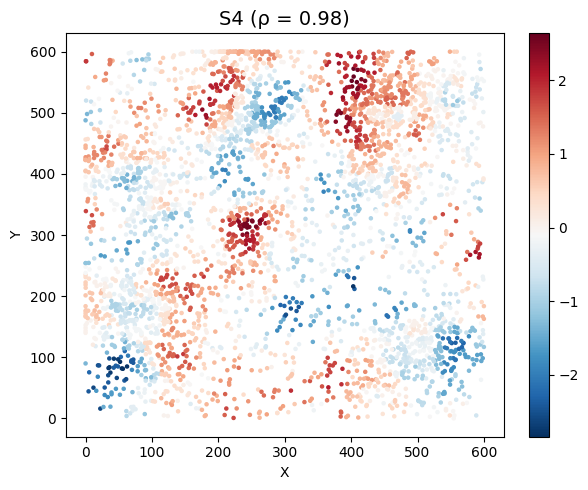

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
cmap = plt.cm.RdBu_r

# Plot S1
sc1 = axes.scatter(loc4[:, 0], loc4[:, 1], c=S4, cmap=cmap,
                      edgecolor="face", s=5)
axes.set_title("S4 (ρ = 0.98)", fontsize=14)
axes.set_xlabel("X")
axes.set_ylabel("Y")
fig.colorbar(sc1, ax=axes, orientation="vertical", fraction=0.065, pad=0.05)

plt.tight_layout()
plt.show()

In [15]:
loc_target = np.array([[point.x, point.y] for point in same_sup.geometry.centroid])

#### Create Y

In [16]:
# for true y relationship 
# Smooth S4 to target support
nbrs_S4 = NearestNeighbors(n_neighbors=25).fit(loc4)
smoothed_S4_to_target = np.zeros(len(loc_target))

for i in range(len(loc_target)):
    distances, indices = nbrs_S4.kneighbors([loc_target[i]])
    smoothed_S4_to_target[i] = np.mean(S4[indices[0]])

# # Smooth S2 to target support
# nbrs_S2 = NearestNeighbors(n_neighbors=25).fit(loc2)
# smoothed_S2_to_target = np.zeros(len(S_target))

# for i in range(len(S_target)):
#     distances, indices = nbrs_S2.kneighbors([loc_target[i]])
#     smoothed_S2_to_target[i] = np.mean(S2[indices[0]])
rng = np.random.default_rng(seed=27)
error_term = rng.normal(0, 0.50, len(loc_target))

y_orig = (uniform_beta * S1) + (radial_beta * S2) + (gradient_beta * S3) + (beta_surface_scaled * smoothed_S4_to_target.reshape(-1,1)) + error_term.reshape(-1,1)

In [17]:
same_sup['y'] = y_orig

In [18]:
df_S4 = gpd.GeoDataFrame({'S4': S4}, geometry=gpd.points_from_xy(loc4[:, 0], loc4[:, 1]))
# df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))

In [19]:
# Spatial join: assign S4 points to 48x48 tracts
S4_agg = gpd.sjoin(df_S4, same_sup, how="left", predicate="within")
# S2_agg = gpd.sjoin(df_S2, tracts_var, how="left", predicate="within")

In [20]:
S4_agg = S4_agg.groupby("tract_id")["S4"].mean().reset_index()

In [21]:
S4_agg

,tract_id,S4
0,3.0,-2.422713
1,4.0,-2.598832
2,6.0,-2.277136
3,9.0,0.126090
4,11.0,0.037833
...,...,...
1588,2299.0,-0.689888
1589,2300.0,-0.168983
1590,2301.0,-0.864293
1591,2302.0,-0.523744


In [22]:
# S2_agg = S2_agg.groupby("tract_id")["S2"].mean().reset_index()

In [23]:
same_sup_df = same_sup.merge(S4_agg, on='tract_id', how='left')
# mgwr_df = mgwr_df.merge(S2_agg, on='tract_id', how='left')
same_sup_df_cp = same_sup_df.copy()
same_sup_df_cp['geometry'] = gpd.points_from_xy(loc_target[:,0], loc_target[:,1])

In [24]:
same_sup_df.isna().sum()

tract_id           0
geometry           0
uniform_beta       0
radial_beta        0
gradient_beta      0
autocorr_beta      0
S1                 0
S2                 0
S3                 0
y                  0
S4               711
dtype: int64

In [25]:
same_sup_df.dropna(inplace=True)
same_sup_df.isna().sum()

tract_id         0
geometry         0
uniform_beta     0
radial_beta      0
gradient_beta    0
autocorr_beta    0
S1               0
S2               0
S3               0
y                0
S4               0
dtype: int64

In [26]:
g_X  = same_sup_df[['S1', 'S2', 'S3', 'S4']].values
g_y = same_sup_df['y'].values.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in same_sup_df['geometry'].centroid])

In [27]:
g_X.shape, g_y.shape

((1593, 4), (1593, 1))

In [28]:
# mgwr_selector = Sel_BW(coords, g_y, g_X, multi=True, constant=False)
# mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
# mgwr_results = MGWR(coords, g_y, g_X, mgwr_selector, constant=False).fit()

In [29]:
# mgwr_results.summary()

In [30]:
# # Assign MGWR results to the same support DataFrame
# same_sup_df['beta_S1'] = mgwr_results.params[:, 0]
# same_sup_df['beta_S2'] = mgwr_results.params[:, 1]
# same_sup_df['beta_S3'] = mgwr_results.params[:, 2]
# same_sup_df['beta_S4'] = mgwr_results.params[:, 3]

# # Set up 2x2 grid
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# # List of beta column names and titles
# beta_cols = ["beta_S1", "beta_S2", "beta_S3", "beta_S4"]
# titles = ["β₁ (S1)", "β₂ (S2)", "β₃ (S3)", "β₄ (S4)"]

# # Flatten axes for easy iteration
# axes_flat = axes.flatten()

# # Plot each beta surface
# for i in range(4):
#     col = beta_cols[i]
#     ax = axes_flat[i]
#     data = same_sup_df[col]

#     # Determine colormap and color scale
#     if data.min() < 0 and data.max() > 0:
#         cmap = plt.cm.RdBu_r
#         max_abs = max(abs(data.min()), abs(data.max()))
#         vmin, vmax = -max_abs, max_abs  # center on 0
#     else:
#         cmap = plt.cm.Reds
#         vmin, vmax = data.min(), data.max()

#     # Plot
#     same_sup_df.plot(column=col, cmap=cmap, linewidth=0.1, edgecolor='k',
#                      ax=ax, vmin=vmin, vmax=vmax)
#     ax.set_title(titles[i], fontsize=14)
#     ax.axis('off')

#     # Colorbar
#     sm = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
#     sm._A = []
#     fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.01)

# plt.tight_layout()
# plt.show()

In [31]:
import sys
sys.path.append("..")
from core.model import GLASS

In [32]:
import tqdm

In [33]:
support_map = [
    {
        'role': 'target', 
        'data': S1
    },
        {
        'role': 'target', 
        'data': S2
    },    
    {
        'role': 'target', 
        'data': S3
    },
    {
        'role': 'source', 
        'data': S4.reshape(-1,1), 
        'source_coords': loc4
    },
]

glass = GLASS(
    coords = loc_target, 
    y = y_orig,
    support_map = support_map,
    K_grid = list(range(2, 50, 5)),
)

In [34]:
glass.fit()

INFO:core.model:Iteration 1
INFO:core.model:Var 0: best K=None, best bw=21, AICc=21405.643
INFO:core.model:Var 1: best K=None, best bw=21, AICc=21405.643
INFO:core.model:Var 2: best K=None, best bw=21, AICc=21405.643
INFO:core.model:Var 3: best K=2, best bw=21, AICc=21405.643
INFO:core.model:Iteration 2
INFO:core.model:Var 0: best K=None, best bw=21, AICc=21405.643
INFO:core.model:Var 1: best K=None, best bw=21, AICc=21405.643
INFO:core.model:Var 2: best K=None, best bw=21, AICc=21405.643
INFO:core.model:Var 3: best K=2, best bw=21, AICc=21405.643
INFO:core.model:Converged.


In [38]:
S4.reshape(-1,1)

array([[ 0.10637579],
       [ 0.08492212],
       [-0.81583564],
       ...,
       [-1.49065201],
       [-1.52781605],
       [-2.2771364 ]], shape=(3600, 1))

In [39]:
y_orig.shape

(2304, 1)

In [43]:
x = 3
glass.params[:,x].min(), glass.params[:,x].max()

(np.float64(24.271800167613698), np.float64(24.271800167613712))

In [44]:
glass.K

[None, None, None, 2]